In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from libs import utils
#import dataframe as df


movie = pd.read_csv('movie_data_for_assignment.csv')
movie.head

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


<bound method NDFrame.head of                                      movie_title             color  \
0                                 Stuart Little              Color   
1                                         Crash              Color   
2              Ghost Rider: Spirit of Vengeance              Color   
3                                    Gettysburg              Color   
4                            Planet of the Apes              Color   
5                         Daredevil                            NaN   
6                      The Pursuit of Happyness              Color   
7                           Kiss Kiss Bang Bang              Color   
8                              Music and Lyrics              Color   
9                               Horrible Bosses              Color   
10                                    Blindness              Color   
11                                    Cleopatra              Color   
12                                  Out of Time             

In [2]:
str_list = [] # Removing coloumns with strings
for colname, colvalue in movie.iteritems():
    if type(colvalue[1]) == str:
         str_list.append(colname)
            
num_list = movie.columns.difference(str_list)         

In [3]:
movie_num = movie[num_list]
# # Extracting 'imdb_score' from dataset and deleting the coloumn from datase
#movie_num.head()
numpyMatrix = movie_num.as_matrix()
print(numpyMatrix.shape)
x_std= numpyMatrix[:, [1,9]]
y_std = numpyMatrix[:, [10]]
testMoviey=y_std[4]
testMoviex=x_std[4]
print(y_std[0])
print(y_std.shape)
nump1 = np.delete(numpyMatrix, [10], axis=1)
movie_num.shape;
print(nump1.shape)
movie_num1=movie_num.drop('imdb_score', axis=1, inplace=True) 


(4300, 16)
[ 5.9]
(4300, 1)
(4300, 15)


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
movie_num = movie_num.fillna(value=0, axis=1) #replacing nan values with 0

In [5]:
X = movie_num.values # Normalizing our data using sklearn

from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)
#y_std=X_std[:, [15]]
print(y_std)

[[ 5.9]
 [ 7.9]
 [ 4.3]
 ..., 
 [ 7.2]
 [ 3.9]
 [ 7.1]]


In [6]:
# Calculating Eigenvectors and eigenvalues of Cov matirx
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

In [7]:
# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort from high to low
eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] 
cum_var_exp = np.cumsum(var_exp) 

In [8]:
pca = PCA(n_components=3) #Running PCA on our normalized data to reduce dimensionality from 15 to 4
x_std = pca.fit_transform(X_std)

In [9]:
ys = y_std
xs = x_std

In [10]:
print(xs.shape)
print(ys.shape)

(4300, 3)
(4300, 1)


In [11]:
# First create a tensorflow session
sess = tf.Session();

# Now create an operation that will calculate the mean of our images
mean_xs = tf.reduce_mean(xs, axis=[1], keep_dims=False, name=None, reduction_indices=None);

In [12]:
mean_xs = sess.run(mean_xs)

In [13]:
print(mean_xs.shape)
mean_xs = np.reshape(mean_xs,(4300,1))
print(mean_xs)

(4300,)
[[-0.22634565]
 [ 0.03644536]
 [ 0.19902708]
 ..., 
 [-2.02340597]
 [ 9.47658805]
 [ 0.26645763]]


In [14]:
mean_xs_4d = tf.reduce_mean(xs, reduction_indices=0, keep_dims=True);
print(mean_xs_4d.get_shape())

(1, 3)


In [15]:
subtraction = xs - mean_xs_4d

# Now computing the standard deviation by calculating the
# square root of the expected squared differences
std_img_op = tf.sqrt(tf.reduce_mean(subtraction * subtraction, reduction_indices=0))
# Now calculate the standard deviation using your session
std_img = sess.run(std_img_op)

In [16]:
#Normalising : by substracting from mean and then dividing by standard devitaion
xs = tf.reshape(xs,[4300,3])
norm_imgs_op = (xs-mean_xs)
norm_imgs_op = norm_imgs_op/std_img;
sess.run(tf.global_variables_initializer());
norm_imgs = sess.run(norm_imgs_op);
xs = norm_imgs

In [17]:
#Converting our imdb values(ys) into one hot encodings of shape (4300,10)
ys=np.asarray(ys)
one_hot_y=np.zeros((4300,10), dtype=float, order='C');
import math
for r in range(4300):
    ys[r]= math.ceil(ys[r])
for r in range(ys.shape[0]):
    i=ys[r];
    i=i[0].astype(int)
    #i=tf.to_int32(i[0])
   # print(i)
    yz=np.zeros((1,10), dtype=float, order='C');
    yz[0,i-1]=1
   # np.append(yz,axis=0)
    np.vstack((one_hot_y,yz))
print(one_hot_y.shape)

(4300, 10)


In [18]:
#Splitting our dataset into training,validation and test set
x_train = xs[range(2000),:]
y_train = ys[range(2000),:]
x_valid = xs[range(2000,3000),:]
y_valid = one_hot_y[range(2000,3000),:]
x_test = xs[range(3000,4300),:]
y_test = one_hot_y[range(3000,4300),:]

In [19]:
#Creating a computational graph on Tensorflow
X = tf.placeholder(tf.float32,name="X",shape=[None,3]);
W = tf.Variable(tf.random_normal([3,5],dtype=tf.float32,stddev = 0.1,name ="W"))
h = tf.matmul(X,W);
b = tf.Variable(tf.constant([0,1],dtype=tf.float32,shape=[5],name = "b"));
h = tf.nn.bias_add(h,b);
h = tf.nn.relu(h);

In [20]:
#Linear function that creates a fully connected layer
def linear(x, n_output, name=None, activation=None, reuse=None):
    
    if len(x.get_shape()) != 2:
        x = flatten(x, reuse=reuse)

    n_input = x.get_shape().as_list()[1]

    with tf.variable_scope(name or "fc", reuse=reuse):
        W = tf.get_variable(
            name='W',
            shape=[n_input, n_output],
            dtype=tf.float32,
            initializer=tf.contrib.layers.xavier_initializer())

        b = tf.get_variable(
            name='b',
            shape=[n_output],
            dtype=tf.float32,
            initializer=tf.constant_initializer(0.0))

        h = tf.nn.bias_add(
            name='h',
            value=tf.matmul(x, W),
            bias=b)

       # h = tf.ceil(h,name=None)

        
        if activation:
            h = activation(h)
            
        return h, W

In [21]:
tf.reset_default_graph()

# Create a placeholder of None x 4 dimensions and dtype tf.float32

X = tf.placeholder(tf.float32,name="X",shape=[None,3]);
Y = tf.placeholder(tf.float32,name="Y",shape=[None,1]);
labels = tf.placeholder(tf.float32,name="labels",shape=[None,10]);


In [22]:
# We'll create 7 hidden layers.  Let's create a variable to say how many neurons we want for each of the layers
h1, W1 = linear(
    x=X, n_output=10, name='linear1', activation=tf.nn.relu)
h2, W2 = linear(
    x=h1, n_output=10, name='linear2', activation=tf.nn.relu)
h3, W3 =  linear(
    x=h2, n_output=10, name='linear3', activation=tf.nn.relu)
Y_pred, W4 =  linear(
    x=h3, n_output=1, name='linear4', activation=None)
#h5, W5 =  linear(
   # x=h4, n_output=5, name='linear5', activation=tf.nn.relu)
#h6,5 W6 =  linear(
   # x=h5, n_output=5, name='linear6', activation=tf.nn.relu)
#h7, W7 =  linear(
 #   x=h6, n_output=5, name='linear7', activation=tf.nn.relu)
#keep_prob = tf.placeholder(tf.float32)
#h_drop = tf.nn.dropout(h5, keep_prob)
#Y_pred, W8 = linear(h1, 10, activation=None, name='pred')

In [23]:
#cost = tf.nn.sigmoid_cross_entropy_with_logits(Y_pred,Y)

In [24]:
# Creating a session and executing out graph by feeding data in mini batches

with tf.Session() as sess:
    #cost = -tf.reduce_sum(Y * tf.log(Y_pred))
    #cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(Y_pred,Y))
    cost =tf.sqrt(tf.reduce_mean(tf.square(tf.sub(Y_pred, Y))))
    correct_prediction = tf.equal(tf.argmax(Y_pred, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
    learning_rate = 0.01
    batch_size=500
    prediction=tf.argmax(Y_pred,1)   
    prediction =tf.shape(prediction)
  #  print prediction.eval(feed_dict={x: mnist.test.images})
    datapoint_size=2000;
#    optimizer = tf.train.AdamOptimizer().minimize(cost)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)    
    print(cost)
    prev_training_accuracy = 0.0
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    saver.save(sess, 'my-model')
    for i in range(10):
        for r in range(100):
            if datapoint_size == batch_size:
                batch_start_idx = 0
            else:
                batch_start_idx = (i * batch_size) % (datapoint_size - batch_size)
                batch_end_idx = batch_start_idx + batch_size
                xb=np.array(x_train[batch_start_idx:batch_end_idx])
                yb=np.array(y_train[batch_start_idx:batch_end_idx])
                #print(correct_prediction.eval(feed_dict={X: xb, Y:yb}))
                train_accuracy = accuracy.eval(feed_dict={
                        X: xb, Y:yb})
                print("step %d, training accuracy %g"%(i, train_accuracy))
                #print(Y_pred.eval({X: x_train, Y:y_train}))
                optimizer.run(feed_dict={X: x_train, Y:y_train})
                prev_training_cost = train_accuracy
    print("validation accuracy %g"%accuracy.eval(feed_dict={
                X: x_valid, Y:y_valid}))
    print("test accuracy %g"%accuracy.eval(feed_dict={
                X: x_test, Y:y_test}))

Tensor("Sqrt:0", shape=(), dtype=float32)
[[ 8.07319164]]
[[ 7.69170141]]
[[ 7.5717473]]
[[ 7.06379986]]
[[ 7.5310483]]


/opt/conda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


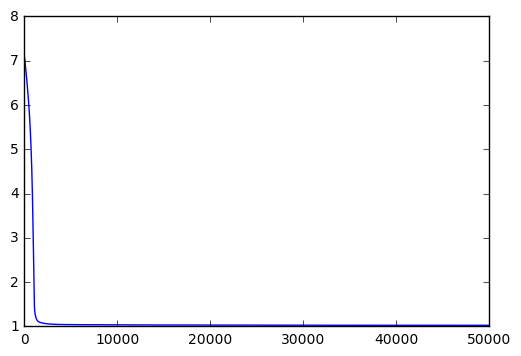

In [25]:
with tf.Session() as sess:
    #cost = -tf.reduce_sum(Y * tf.log(Y_pred))
    #cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(Y_pred,Y))
    cost =tf.sqrt(tf.reduce_mean(tf.square(tf.sub(Y_pred, Y))))
    correct_prediction = tf.equal(Y_pred,Y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
    learning_rate = 0.001
    batch_size=500
    prediction=tf.argmax(Y_pred,1)   
    prediction =tf.shape(prediction)
  #  print prediction.eval(feed_dict={x: mnist.test.images})
    datapoint_size=2000;
#    optimizer = tf.train.AdamOptimizer().minimize(cost)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)    
    print(cost)
    prev_training_accuracy = 0.0
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    saver.save(sess, 'my-model')
    errors = []
    for i in range(500):
        for r in range(100):
            if datapoint_size == batch_size:
                batch_start_idx = 0
            else:
                batch_start_idx = (i * batch_size) % (datapoint_size - batch_size)
                batch_end_idx = batch_start_idx + batch_size
                xb=np.array(x_train[batch_start_idx:batch_end_idx])
                yb=np.array(y_train[batch_start_idx:batch_end_idx])
                #print(correct_prediction.eval(feed_dict={X: xb, Y:yb}))
                train_accuracy = accuracy.eval(feed_dict={
                        X: xb, Y:yb})
               # print("step %d, training accuracy %g"%(i, train_accuracy))
                errors.append(cost.eval({X: x_train, Y:y_train}))
                optimizer.run(feed_dict={X: x_train, Y:y_train})
             #   if(correct_prediction.eval(feed_dict={X: xb, Y:yb})==True):
             #       print(Y);
                prev_training_cost = train_accuracy
#    print("validation accuracy %g"%accuracy.eval(feed_dict={
  #              X: x_valid, Y:y_valid}))
 #   print("test accuracy %g"%accuracy.eval(feed_dict={
   #             X: x_test, Y:y_test}))
    print(Y_pred.eval(feed_dict={X:np.reshape(x_train[3],[1,3]),Y:np.reshape(y_train[3],[1,1])}))
    print(Y_pred.eval(feed_dict={X:np.reshape(x_train[1],[1,3]),Y:np.reshape(y_train[1],[1,1])}))    
    print(Y_pred.eval(feed_dict={X:np.reshape(x_train[6],[1,3]),Y:np.reshape(y_train[6],[1,1])}))    
    print(Y_pred.eval(feed_dict={X:np.reshape(x_train[7],[1,3]),Y:np.reshape(y_train[7],[1,1])}))
    print(Y_pred.eval(feed_dict={X:np.reshape(x_train[9],[1,3]),Y:np.reshape(y_train[9],[1,1])}))
    
    plt.plot([np.mean(errors[i-20:i]) for i in range(len(errors))])
    plt.show()
    plt.savefig("errors.png")